In [39]:
import os 
import re 
import ast
import random 
from abc import ABC, abstractmethod
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

MAIN_PATH = os.path.join("/Users", "jcheigh", "Thesis")
DATA_PATH = os.path.join(MAIN_PATH, "data")
PLOT_PATH = os.path.join(MAIN_PATH, "plots")
RES_PATH  = os.path.join(MAIN_PATH, "results")

PLOT_PATHS = {
    "error plots"     : f"{PLOT_PATH}/error plots/",
    "char plots"      : f"{PLOT_PATH}/char sum plots/",   
    "fourier plots"   : f"{PLOT_PATH}/fourier plots/",   
    }

PLOT_NAME  = {
    "error plots"     : r"p = (?P<prime>\d+) error plot.jpg",
    "char plots"      : r"p = (?P<prime>\d+) char sum plot.jpg",
    "fourier plots"   : r"p = (?P<prime>\d+) fourier exp plot.jpg"
    }

PLOT_PARAMS = {
    "error plots"     : ("prime"),
    "char plots"      : ("prime"),
    "fourier plots"   : ("prime"),
    }

CSV_PATHS = {
    "raw error"       : f"{DATA_PATH}/raw_error.csv",
    "processed_error" : f"{DATA_PATH}/processed_error.csv",
    "error stats"     : f"{DATA_PATH}/error stats.csv",
    "fourier stats"   : f"{DATA_PATH}/polya fourier stats.csv",
    "char sum stats"  : f"{DATA_PATH}/char sum stats.csv"
    }

EXP_PATHS = {
    "character sum"   : f"{DATA_PATH}/char sum lists/",
    "polya fourier"   : f"{DATA_PATH}/polya fourier lists/",
    "symmetry"        : f"{DATA_PATH}/symmetry/",
    "leg fixed n"     : f"{DATA_PATH}/legendre fixed n/",
    "error lists"     : f"{DATA_PATH}/error lists/",
    'antisymmetry'    : f"{DATA_PATH}/antisymmetry/",
    'translation'     : f"{DATA_PATH}/translation"
    }  

EXP_NAME = {
    "symmetry"        : r"symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    "polya fourier"   : r"p = (?P<prime>\d+) fourier exp list",
    "character sum"   : r"p = (?P<prime>\d+) character sum list",
    "leg fixed n"     : r"n = (?P<n>\d+) legendre symbol list",
    "error lists"     : r"p = (?P<prime>\d+) error list",
    'antisymmetry'    : r"antisymmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    'translation'     : 'translation means'
    } 

EXP_PARAMS = {
    "symmetry"        : ('prime', 'delta'),
    "polya fourier"   : ("prime"),
    "character sum"   : ("prime"),
    "leg fixed n"     : ('n'),
    "error lists"     : ("prime"),
    "antisymmetry"    : ('prime', 'delta'),
    'translation'     : ()
    }   

def process(lst):
    processed_lst = []  

    for item in lst:
        # If the item starts with a '(', consider it a tuple
        if item.startswith('('):
            try:
                # Safely evaluate the item as a tuple
                processed_tuple = ast.literal_eval(item)
                processed_lst.append(processed_tuple)
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)
        else:
            try:
                # Convert the item to a float
                processed_lst.append(float(item))
            except ValueError:
                # If there's an error, just append the original string
                processed_lst.append(item)

    return processed_lst

def fetch_data(experiment):
    ### Usage: fetch_data('polya fourier')
    path   = EXP_PATHS[experiment]  # f"{DATA_PATH}/symmetry/",
    name   = EXP_NAME[experiment]   # symmetry\(p=(?P<prime>\d+),d=(?P<delta>\d+)\)",
    params = EXP_PARAMS[experiment] # (prime, delta)
    
    data = {}
    for filename in os.listdir(path):
        # Match the filename with the regex pattern
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            # Read the file and get the list of elements
            with open(os.path.join(path, filename), 'r') as file:
                elements = [line.strip() for line in file.readlines()]

            elements = process(elements)
            # Update the global dictionary
            data[key] = elements

    return data 

def read_csv(name):
    ### Usage: read_csv('processed_error')
    return pd.read_csv(CSV_PATHS[name])

def get_plot_dict(name):
    ### returns {105601 : "/Users/jcheigh/Thesis/..."}
    path   = PLOT_PATHS[name]
    params = PLOT_PARAMS[name]
    name   = PLOT_NAME[name]

    result = {}
    for filename in os.listdir(path):
        match = re.search(name, filename)
        if match:
            if isinstance(params, str):
                key = int(match.group(params))
            elif isinstance(params, tuple):
                key = tuple([int(match.group(param)) for param in params]) # (17, 3)
            else:
                raise Exception(f"Invalid Params Type: {params}")

            result[key] = os.path.join(path, filename)
    
    return result

def plot(name, params=None, N=1):
    path_map = get_plot_dict(name)
    
    if params:
        # use params
        paths = [path_map[param] for param in params]

    else:
        # or random N
        paths = random.choices(list(path_map.values()), k=N)

    for path in paths:
        try:
            img = Image.open(path)
            plt.figure(figsize = (20,10))
            plt.imshow(img)
            plt.axis('off')  # Turn off axis
            plt.show()
        except Exception:
            print(f"Plot failed")

class Saver(ABC):
    
    @property
    @abstractmethod
    def path(self):
        """Abstract property for the path where files should be saved."""
        raise NotImplementedError

    @property
    @abstractmethod 
    def type(self):
        """Abstract property for data type: one of (plot, df, list)"""
        raise NotImplementedError

    @abstractmethod
    def get_name(self, params):
        """Abstract method to generate the filename based on the parameters."""
        raise NotImplementedError
    
    def __init__(self):
        # Check if path exists, and create it if it doesn't
        if not os.path.exists(self.path):
            os.makedirs(self.path)
    
    def _get_full_path(self, name, extension):
        """Construct the full path."""
        return os.path.join(self.path, f"{name}.{extension}")

    def _check_overwrite(self, path):
        """Check if file exists and handle overwriting."""
        if os.path.exists(path):
            print(f"Overwriting {path}")
            with open(path, 'r') as f:
                original_data = f.read()
            return original_data
        return None

    def _save_data(self, params, data):
        """Save data to the specified path."""
        name = self.get_name(params)
        
        if self.type == "df":
            # Save DataFrame to .csv
            path = self._get_full_path(name, "csv")
            data.to_csv(path, index=False)
            return None

        elif self.type == "list":
            # Save list to .txt
            path = self._get_full_path(name, "txt")
            original_data = self._check_overwrite(path)
            with open(path, 'w') as f:
                for item in data:
                    f.write(f"{item}\n")
            return original_data

        elif self.type == 'plot':
            # Save plt object to .png
            path = self._get_full_path(name, "jpg")
            data.savefig(path)
            return None

        else:
            raise TypeError("Unsupported data type for saving.")

    def save(self, params, data):
        return self._save_data(params, data)

def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (10,8))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title = None, savefig = False, savename = None):
    # distribution of categorical
    plt.figure(figsize = (10,8))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title = None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (10, 8))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(10, 8))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def char_sum_plot(prime):
    fig, ax = plt.subplots(figsize=(20,10))
    x = list(range(0, prime))
    y = char_sum_data[prime]
    ax.plot(x, y, label=f"S_p(x) for p = {prime}")

    mean, sd = np.mean(y), np.std(y)
    largest, smallest = max(y), min(y)
    
    ax.axhline(y=mean, color='b', linestyle='--', label=f"Mean(S_p(x) = {round(mean, 3)}")
    ax.axhline(y=mean + sd, color='r', linestyle='--', label=f"+1 SD = {round(mean,3)} + {round(sd, 3)}")
    ax.axhline(y=mean - sd, color='r', linestyle='--', label=f"-1 SD = {round(mean,3)} - {round(sd, 3)}")
    ax.axhline(y=largest, color='b', linestyle='--', label=f"Max(S_p(x)) = {round(largest, 3)}")
    ax.axhline(y=smallest, color='b', linestyle='--', label=f"Min(S_p(x)) = {round(smallest,3)}")
  
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("x")
    ax.set_ylabel('char sum')
    ax.set_title(f"Char Sum for p = {prime} (p = {prime % 4} mod 4)")
    return fig
    
"""Example Usage of Saver"""

class ErrorPlotSaver(Saver):
    path = PLOT_PATH
    type = 'plot'

    def get_name(self, params):
        if isinstance(params, tuple):
            prime = params[0]
        elif isinstance(params, int):
            prime = params
        else:
            raise TypeError("params should be a tuple or an integer")

        return f"p = {prime} error plot"

### USAGE:
### saver = ErrorPlotSaver()
### plot = error_plot(p)
### saver.save(plot, p)

In [46]:
df = read_csv("error stats")
df.head()

,prime,max,min,mean,median,std dev,x_max,x_min,half,least quad nonres
0,117443.0,13.118478,-37.687117,-1.055982e+01,-10.441185,6.602119,39737,117147,False,NaN
1,189253.0,31.348191,-31.358018,1.585884e-16,0.000252,8.062329,124732,64520,False,NaN
2,102407.0,34.892214,-16.271328,1.158248e+01,11.386864,6.233913,28847,73341,False,NaN
3,122131.0,19.219864,-28.995691,-5.723634e+00,-5.771375,6.708070,48852,97704,False,NaN
4,118163.0,31.376575,-17.644746,5.898056e+00,5.857841,6.622325,113656,102504,False,NaN


In [47]:
df["mod"] = df["prime"].apply(lambda prime : prime % 4)
df.rename(columns={'max': 'max_pos_error', "min" : 'max_neg_error', 
                   "x_max" : "x_pos_error", "x_min" : 'x_neg_error'}, inplace=True)
df['max_error'] = df.apply(lambda row: max(row['max_pos_error'], -1 * row['max_neg_error']), axis = 1)
df['max_error_ind'] = np.where(df['max_error'] == df['max_pos_error'], 1, 0)
df["x_max_error"]   = np.where(df["max_error_ind"] == 1, df["x_pos_error"], df["x_neg_error"])
df['var'] = df['std dev'].apply(lambda x : x ** 2)
df["log error"] = df["prime"].apply(lambda p : np.floor(np.log(p) ** 2))
df["p/log(p)^2"] = df["prime"].apply(lambda p : p / (np.log(p)**2))
df['normalized mean'] = df.apply(lambda row : row["mean"] / row["prime"], axis=1)
df['normalized max error'] = df.apply(lambda row : row["max_error"] / row["prime"], axis=1)
df.head()

,prime,max_pos_error,max_neg_error,mean,median,std dev,x_pos_error,x_neg_error,half,least quad nonres,mod,max_error,max_error_ind,x_max_error,var,log error,p/log(p)^2,normalized mean,normalized max error
0,117443.0,13.118478,-37.687117,-1.055982e+01,-10.441185,6.602119,39737,117147,False,NaN,3.0,37.687117,0,117147,43.587970,136.0,861.805886,-8.991446e-05,0.000321
1,189253.0,31.348191,-31.358018,1.585884e-16,0.000252,8.062329,124732,64520,False,NaN,1.0,31.358018,0,64520,65.001155,147.0,1281.829218,8.379702e-22,0.000166
2,102407.0,34.892214,-16.271328,1.158248e+01,11.386864,6.233913,28847,73341,False,NaN,3.0,34.892214,1,28847,38.861668,133.0,769.423888,1.131024e-04,0.000341
3,122131.0,19.219864,-28.995691,-5.723634e+00,-5.771375,6.708070,48852,97704,False,NaN,3.0,28.995691,0,97704,44.998202,137.0,890.227049,-4.686471e-05,0.000237
4,118163.0,31.376575,-17.644746,5.898056e+00,5.857841,6.622325,113656,102504,False,NaN,3.0,31.376575,1,113656,43.855187,136.0,866.182063,4.991457e-05,0.000266


In [48]:
df_full = df

In [49]:
print(f"Analyzed {len(df)} primes")

Analyzed 4377 primes


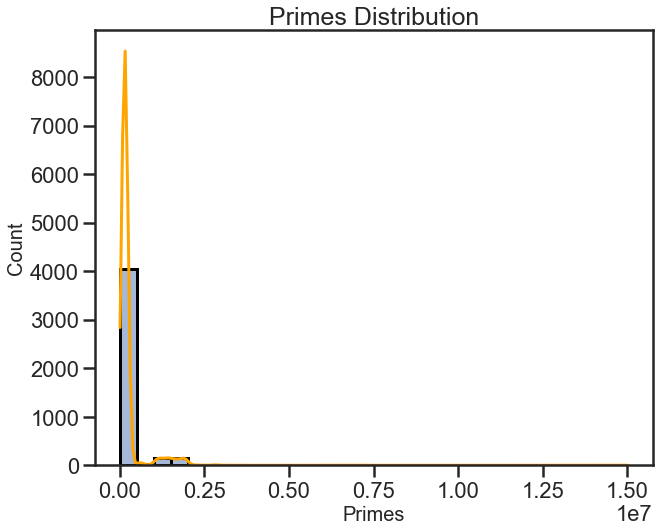

<AxesSubplot:title={'center':'Primes Distribution'}, xlabel='Primes', ylabel='Count'>

In [50]:
histplot(df["prime"], xlabel="Primes")

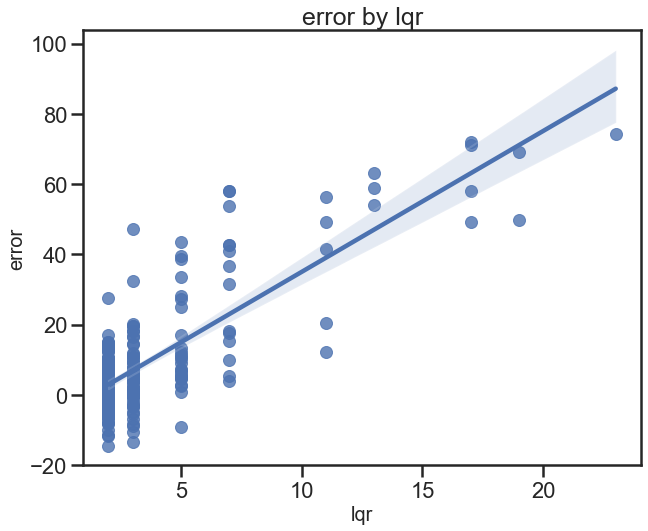

<AxesSubplot:title={'center':'error by lqr'}, xlabel='lqr', ylabel='error'>

In [54]:
lqr = df[(df["least quad nonres"] != 'N/A') & (df["mod"] == 3)]
scatter(lqr["least quad nonres"], lqr["mean"], xlabel='lqr', ylabel='error')

In [7]:
df = df[df["prime"] < 1000000] # for now just smallprimes

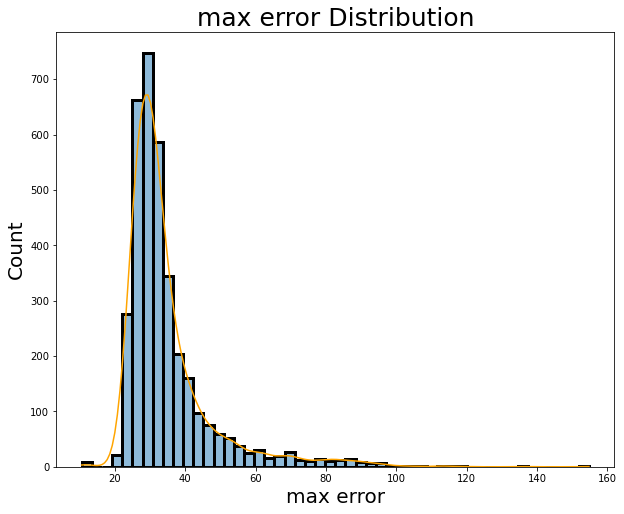

<AxesSubplot:title={'center':'max error Distribution'}, xlabel='max error', ylabel='Count'>

In [20]:
histplot(df["max_error"], bins = 50, xlabel="max error")

What distribution is this? Poisson? Beta? 



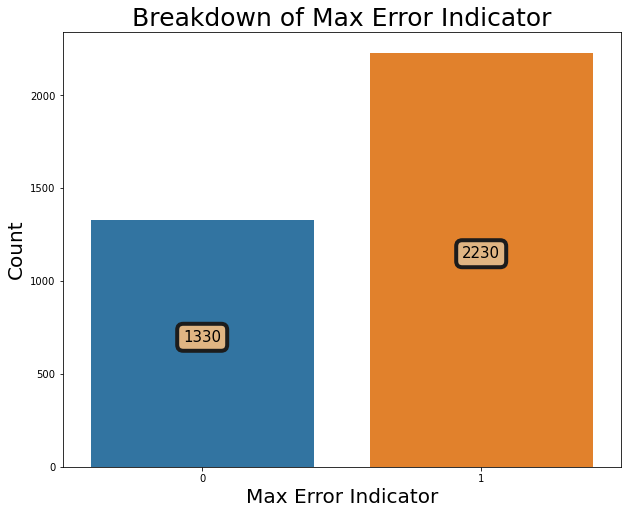

<AxesSubplot:title={'center':'Breakdown of Max Error Indicator'}, xlabel='Max Error Indicator', ylabel='Count'>

In [21]:
countplot(df["max_error_ind"], xlabel="Max Error Indicator")

In [24]:
df3 = df[df['mod'] == 3]
df1 = df[df['mod'] == 1]

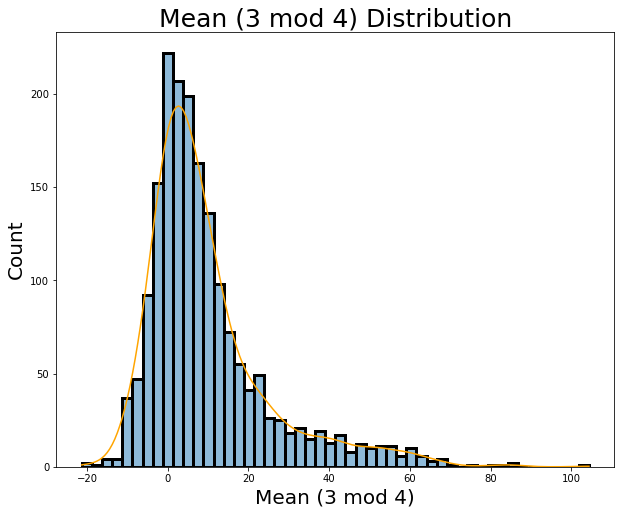

<AxesSubplot:title={'center':'Mean (3 mod 4) Distribution'}, xlabel='Mean (3 mod 4)', ylabel='Count'>

In [25]:
histplot(df3["mean"], bins=50, xlabel="Mean (3 mod 4)")

I wonder what is causing the mean of 3 mod 4 to be this way

In [28]:
fourier_lsts = fetch_data('polya fourier')
char_lsts = fetch_data("character sum")

In [34]:
primes = list(set(fourier_lsts.keys()).intersection(char_lsts.keys()))
primes = [p for p in primes if p % 4 == 3]
fourier_means = [np.mean(fourier_lsts[prime]) for prime in primes]
char_means = [np.mean(char_lsts[prime]) for prime in primes]

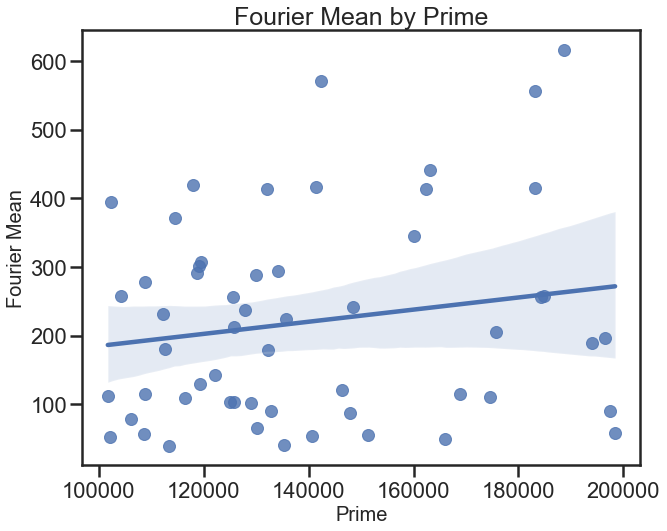

<AxesSubplot:title={'center':'Fourier Mean by Prime'}, xlabel='Prime', ylabel='Fourier Mean'>

In [35]:
scatter(primes, fourier_means, xlabel="Prime", ylabel="Fourier Mean")

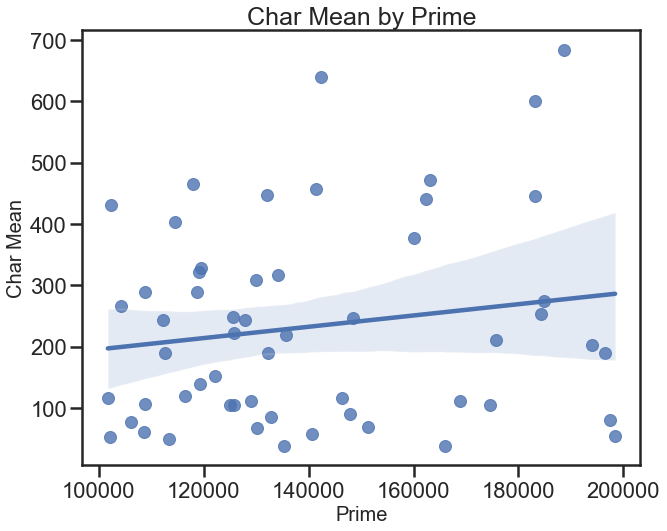

<AxesSubplot:title={'center':'Char Mean by Prime'}, xlabel='Prime', ylabel='Char Mean'>

In [37]:
scatter(primes, char_means, xlabel="Prime", ylabel="Char Mean")

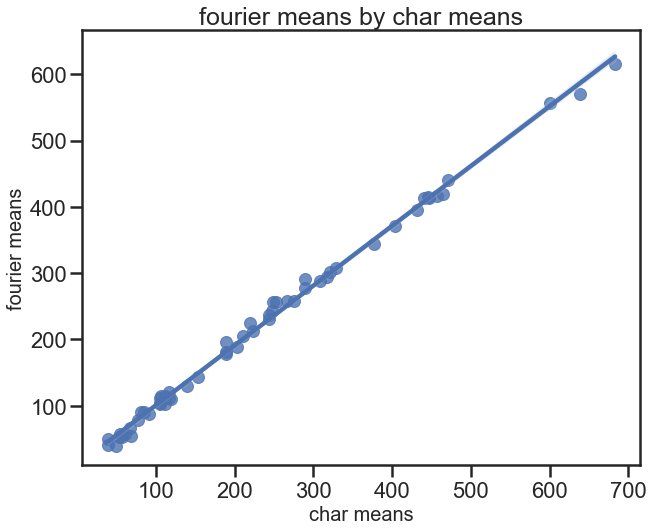

<AxesSubplot:title={'center':'fourier means by char means'}, xlabel='char means', ylabel='fourier means'>

In [38]:
scatter(char_means, fourier_means, xlabel="char means", ylabel="fourier means")

Given that variance might be pretty predictable given the prime this distribution and the max one might converge to the same thing. The thing is that this one you could be able to model easier (easier confidence interval)

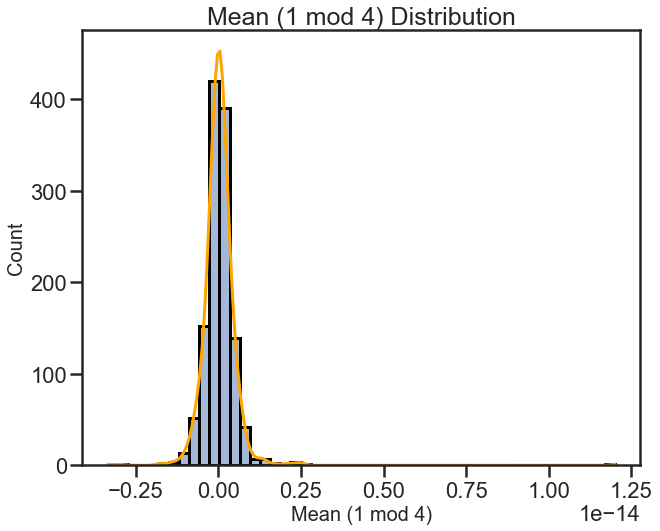

<AxesSubplot:title={'center':'Mean (1 mod 4) Distribution'}, xlabel='Mean (1 mod 4)', ylabel='Count'>

In [153]:
histplot(df1["mean"], bins=50, xlabel="Mean (1 mod 4)")

In [154]:
df1[df1['mean'] < -.6 * 10e-15]

,prime,max_pos_error,max_neg_error,mean,median,std dev,x_pos_error,x_neg_error,half,mod,max_error,max_error_ind,x_max_error,var,log error,p/log(p)^2


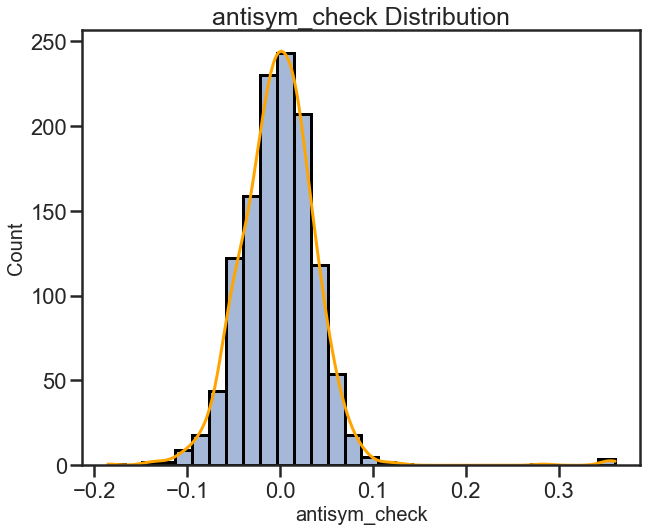

<AxesSubplot:title={'center':'antisym_check Distribution'}, xlabel='antisym_check', ylabel='Count'>

In [155]:
histplot(df1['max_pos_error'] + df1['max_neg_error'], xlabel='antisym_check')

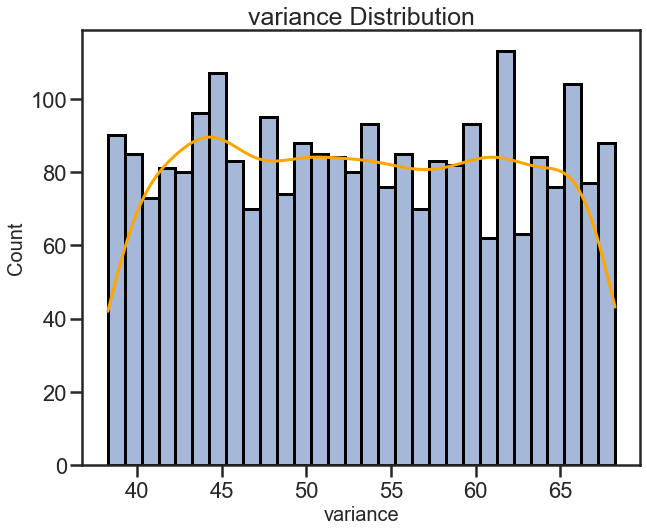

<AxesSubplot:title={'center':'variance Distribution'}, xlabel='variance', ylabel='Count'>

In [156]:
histplot(df["var"], xlabel="variance")

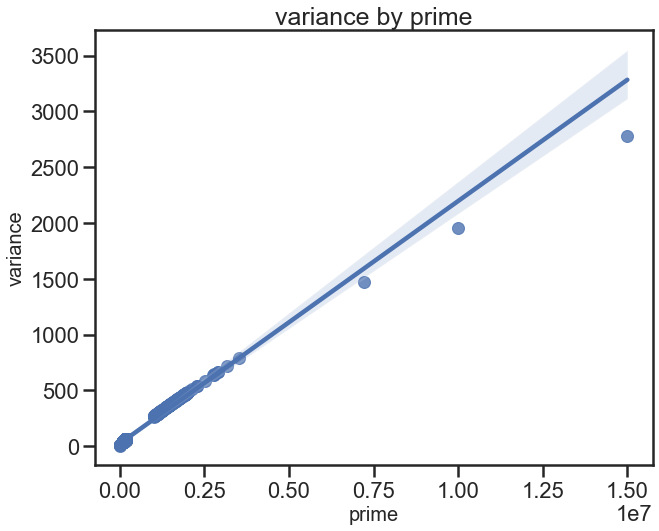

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [164]:
scatter(df_full["prime"], df_full["var"], xlabel="prime", ylabel='variance')

So it's not linear

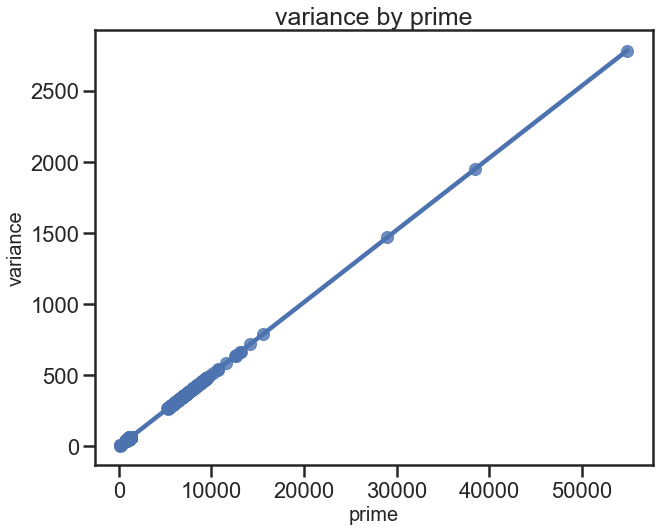

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [165]:
scatter(df_full["p/log(p)^2"], df["var"], xlabel="prime", ylabel='variance')

This is closer.

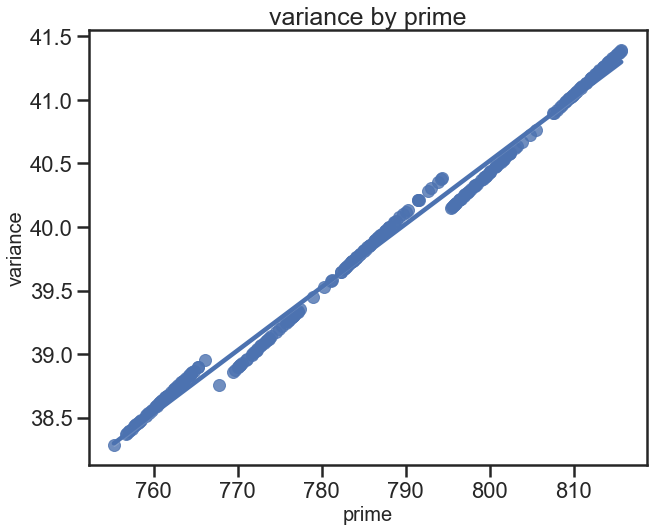

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [240]:
subset = df[(df["prime"] < 110000) & (df['prime'] > 100000)]
scatter(subset["p/log(p)^2"], subset["var"], xlabel="prime", ylabel='variance')

Nope, not p/log(p)^2 exactly either

breaks: 102000,106500, 111200, 116000

In [235]:
sorted_df = df_full.sort_values(by='prime')

vars = {var : prime for var, prime in zip(sorted_df["var"], sorted_df["prime"])}

diffs = []
avgs = []
for var1, var2 in zip(list(vars.keys()), list(vars.keys())[1:]):
    if var2 < var1:
        print('=' * 15)
        diff = var1-var2
        diffs.append(diff)
        avg = (int(vars[var1]) + int(vars[var2])) / 2
        avgs.append(avg)
        print(f"Diff: {var1-var2}")
        print(f"Prime: {(int(vars[var1]) + int(vars[var2])) / 2}")


Diff: 0.19311087239319136
Prime: 102009.0
Diff: 0.24077299308685696
Prime: 106512.0
Diff: 0.2835378842928904
Prime: 111183.0
Diff: 0.2985511485227548
Prime: 116073.0
Diff: 0.32033931762470047
Prime: 121148.0
Diff: 0.27587726675201196
Prime: 126339.0
Diff: 0.3392852471853587
Prime: 131900.0
Diff: 0.34482042795048073
Prime: 137608.0
Diff: 0.3621517183352623
Prime: 143532.0
Diff: 0.3618601864390385
Prime: 149709.0
Diff: 0.3661493492685324
Prime: 156090.0
Diff: 0.38709605065193387
Prime: 162764.0
Diff: 0.28219821710199966
Prime: 169608.0
Diff: 0.4063784368521013
Prime: 176829.0
Diff: 0.36999213744901027
Prime: 184279.0
Diff: 0.33489573137694606
Prime: 192159.0
Diff: 0.2879496756906974
Prime: 1003828.0
Diff: 1.052714003531264
Prime: 1119240.0
Diff: 1.5567736135314476
Prime: 1386380.0
Diff: 0.8431541516877132
Prime: 1437813.0
Diff: 1.3290759458797083
Prime: 1486611.0
Diff: 1.7170028219710503
Prime: 1652694.0
Diff: 0.6886138900214291
Prime: 1772688.0
Diff: 0.5867500023866228
Prime: 1835200.0


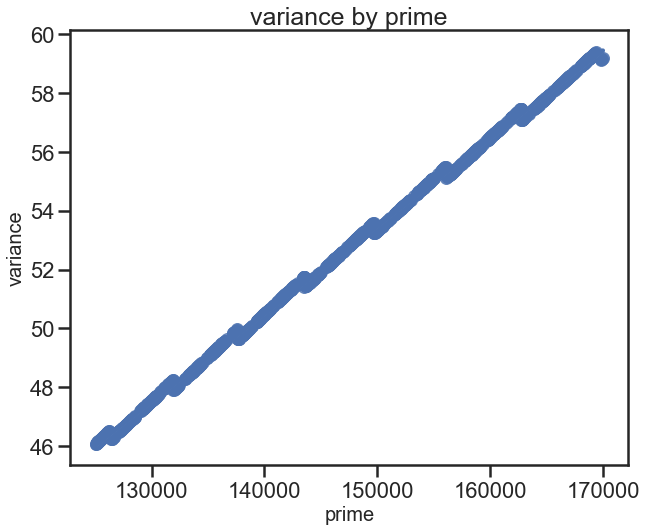

<AxesSubplot:title={'center':'variance by prime'}, xlabel='prime', ylabel='variance'>

In [226]:
subset = df[(df["prime"] < 170000) & (df['prime'] > 125000)]
scatter(subset['prime'], subset["var"], xlabel="prime", ylabel='variance')

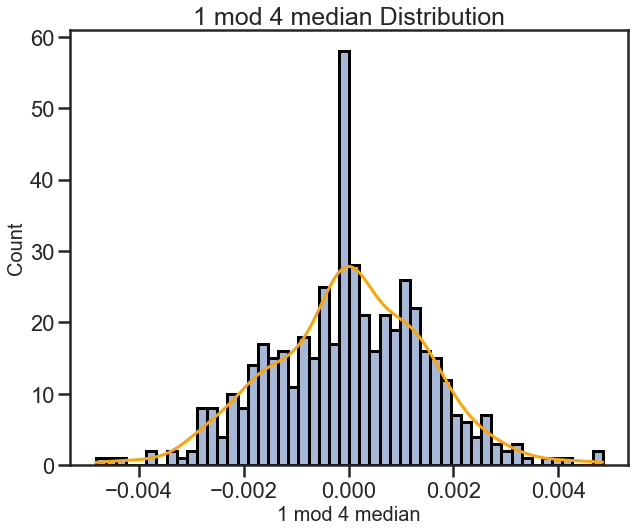

<AxesSubplot:title={'center':'1 mod 4 median Distribution'}, xlabel='1 mod 4 median', ylabel='Count'>

In [51]:
histplot(df1["median"], bins=50, xlabel='1 mod 4 median')

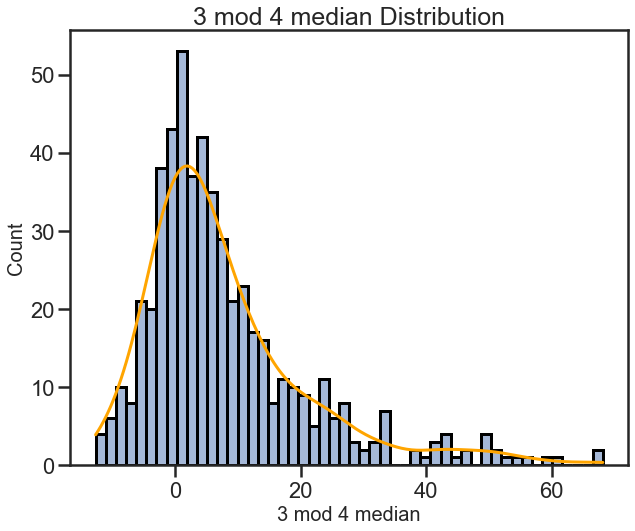

<AxesSubplot:title={'center':'3 mod 4 median Distribution'}, xlabel='3 mod 4 median', ylabel='Count'>

In [52]:
histplot(df3["median"], bins=50, xlabel='3 mod 4 median')

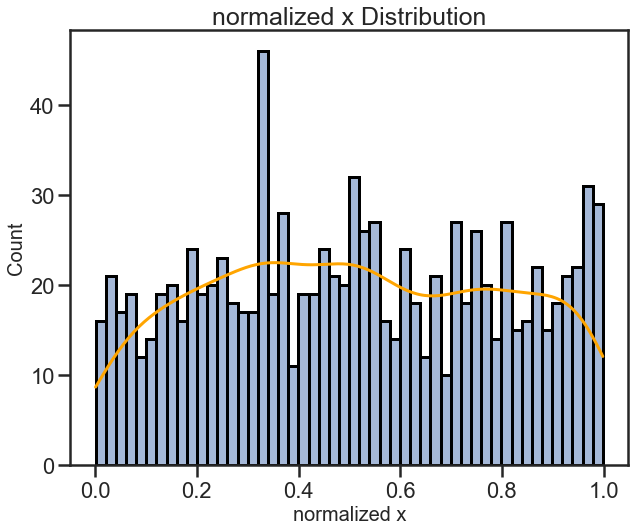

<AxesSubplot:title={'center':'normalized x Distribution'}, xlabel='normalized x', ylabel='Count'>

In [57]:
histplot(df["x_max_error"] / df["prime"], bins = 50,xlabel = "normalized x")

### When translations

In [263]:
df3_full = df_full[df_full["mod"] == 3]
df1_full = df_full[df_full['mod'] == 1]

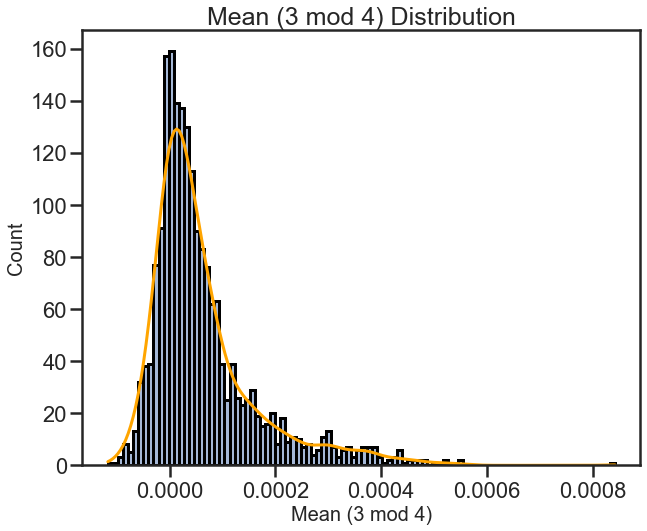

<AxesSubplot:title={'center':'Mean (3 mod 4) Distribution'}, xlabel='Mean (3 mod 4)', ylabel='Count'>

In [264]:
histplot(df3_full["normalized mean"], bins=100, xlabel="Mean (3 mod 4)")